In [82]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
import geopandas as gpd
import pandas as pd
from datetime import datetime as dt
os.chdir('/disk/scratch/local.4/harry/TDX/')

In [2]:
coh = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc').coherence
loc1 = '/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/core_plot_shapefiles/core_plots.shp'
loc2 = '/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/Forest_inventory/PeruPlots.csv'
plots = gpd.read_file(loc1)
plots[['P' in p for p in plots.layer]]
plot_data = pd.read_csv(loc2)
plots = pd.merge(plot_data,plots,left_on='Plot',right_on='layer')[['Plot','AGB_loss','AGB_loss_pct','geometry']]

metadata= pd.read_csv('/home/s1332488/Chapter3/peru_TDX_metadata.csv')
spot = metadata[metadata.imaging_mode=='HS']
spotD = spot[spot.orbit_direction == 'D']
spotD = spotD.sort_values(by='file')
spotD['t']=[dt.strptime(DATE,'%d/%m/%Y') for DATE in spotD.date]
spotD_xr = spotD[['height_of_ambiguity','t']].set_index('t').to_xarray()
spotD_xr = spotD_xr.interp_like(coh,method='nearest')
coh = xr.merge([coh,spotD_xr])

In [3]:
plots

,Plot,AGB_loss,AGB_loss_pct,geometry
0,PC1,80.855146,28.272495,"POLYGON ((-69.72334 -11.03299, -69.72334 -11.0..."
1,PC2,23.673491,7.760784,"POLYGON ((-69.72407 -11.02679, -69.72365 -11.0..."
2,PC3,34.778204,10.708270,"POLYGON ((-69.72240 -11.02397, -69.72194 -11.0..."
3,PC4,37.828376,17.795986,"POLYGON ((-69.71629 -11.02172, -69.71610 -11.0..."


In [4]:
coh_rio = coh.rename({'lat':'y','lon':'x'})

In [5]:
coh_rio

<xarray.Dataset>
Dimensions:              (t: 23, y: 2350, x: 2818)
Coordinates:
  * t                    (t) datetime64[ns] 2019-06-16T10:19:03 ... 2021-09-2...
  * y                    (y) float64 -11.0 -11.0 -11.0 ... -11.06 -11.06 -11.06
  * x                    (x) float64 -69.76 -69.76 -69.76 ... -69.68 -69.68
Data variables:
    coherence            (t, y, x) float64 ...
    height_of_ambiguity  (t) float64 41.68 42.73 44.04 45.39 ... 65.18 82.16 nan
Attributes: (12/15)
    transform:                 [ 2.74774877e-05  0.00000000e+00 -6.97578870e+...
    crs:                       +init=epsg:4326
    res:                       [2.74774877e-05 2.69681660e-05]
    is_tiled:                  0
    nodatavals:                nan
    scales:                    1.0
    ...                        ...
    TIFFTAG_DOCUMENTNAME:      /data/HR_Data/TSM_TDM_SARData/science/320_TDX_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.5.1, Exelis Visual Information Solutions...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100

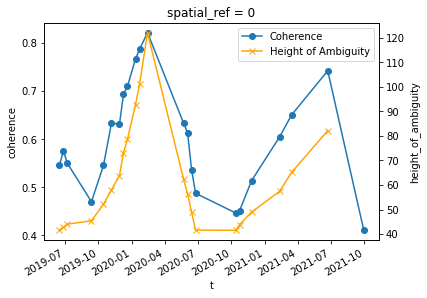

In [6]:
ln1=coh_rio.coherence.rio.clip(plots[plots.Plot=='PC1'].geometry).mean(dim=['x','y']).plot(marker='o',
                                                                                      label='Coherence')
plt.twinx()
ln2=coh_rio.height_of_ambiguity.plot(color='orange',label='Height of Ambiguity',marker='x')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

In [7]:
avg_coh = coh.coherence.mean(dim=['lat','lon'])
coh['anom'] = (coh.coherence / avg_coh).rio.write_crs('EPSG:4326')

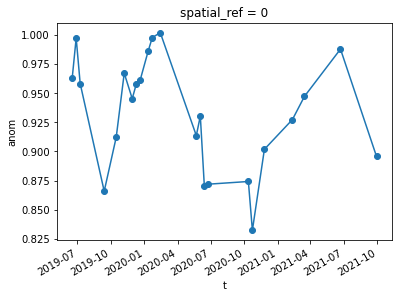

In [8]:
coh_rio = coh.rename({'lat':'y','lon':'x'})
coh_rio.anom.rio.clip(plots[plots.Plot=='PC1'].geometry).mean(dim=['x','y']).plot(marker='o',
                                                                                      label='Coherence')

In [9]:
plots

,Plot,AGB_loss,AGB_loss_pct,geometry
0,PC1,80.855146,28.272495,"POLYGON ((-69.72334 -11.03299, -69.72334 -11.0..."
1,PC2,23.673491,7.760784,"POLYGON ((-69.72407 -11.02679, -69.72365 -11.0..."
2,PC3,34.778204,10.708270,"POLYGON ((-69.72240 -11.02397, -69.72194 -11.0..."
3,PC4,37.828376,17.795986,"POLYGON ((-69.71629 -11.02172, -69.71610 -11.0..."


In [83]:
pth = '/exports/csce/datastore/geos/users/s1332488/Chapter3/CHM_Belgica_T1_3m.tif'
chm = rx.open_rasterio(pth).rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
chm = chm.sel(band=1).drop('band')

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/rioxarray/raster_array.py:127: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


In [89]:
AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)

chm.sel(lon=AOI_lon, lat=AOI_lat).where(chm>-100).mean()

<xarray.DataArray ()>
array(22.524727, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [12]:
coh = xr.merge([coh,chm.interp_like(coh).rename('chm')])
coh['chm'] = coh.chm.where(coh.chm > -1)

In [13]:
coh['initial'] = coh.coherence.isel(t=0)


In [19]:
coh_50m = coh.initial.coarsen(lat=18,lon=18,boundary='trim').mean()
chm_50m = coh.chm.coarsen(lat=18,lon=18,boundary='trim').mean()


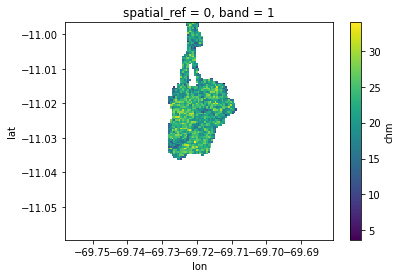

In [150]:
chm_50m.plot()

In [20]:
merge50 = xr.merge([coh_50m,chm_50m])

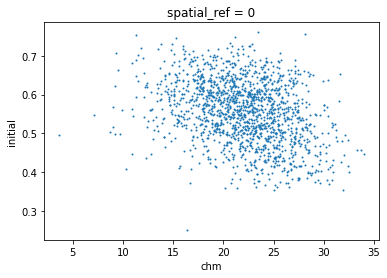

In [21]:
merge50.plot.scatter(x='chm',y='initial',s=1)

In [49]:
dem = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc').height.isel(t=0)

In [74]:
AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)
srtm = rx.open_rasterio('peru_amended_smooth_crop_nans.tif').sel(y=AOI_lat,x=AOI_lon)

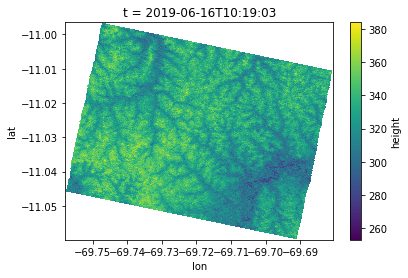

In [51]:
dem.plot()

In [75]:
srtm = srtm.rename({'x':'lon','y':'lat'}).interp_like(dem,method='cubic').sel(band=1).drop('band')

In [72]:
xr.merge([dem,srtm.rename('dem')])

<xarray.Dataset>
Dimensions:      (lat: 3017, lon: 3651)
Coordinates:
  * lat          (lat) float64 -11.06 -11.06 -11.06 -11.06 ... -11.0 -11.0 -11.0
  * lon          (lon) float64 -69.76 -69.76 -69.76 ... -69.68 -69.68 -69.68
    t            datetime64[ns] 2019-06-16T10:19:03
    spatial_ref  int64 0
Data variables:
    height       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    dem          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/15)
    transform:                 [ 2.74774911e-05  0.00000000e+00 -6.97578869e+...
    crs:                       +init=epsg:4326
    res:                       [2.74774911e-05 2.69681660e-05]
    is_tiled:                  0
    nodatavals:                nan
    scales:                    1.0
    ...                        ...
    TIFFTAG_DOCUMENTNAME:      /data/HR_Data/TSM_TDM_SARData/science/320_TDX_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.5.1, Exelis Visual Information Solutions...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100

In [37]:
dem50std = dem.coarsen(lat=18,lon=18,boundary='trim').std()

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [39]:
merge50 = xr.merge([merge50,dem50std.interp_like(merge50).rename('dz')],compat='override')

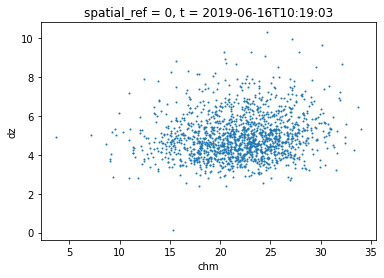

In [40]:
merge50.plot.scatter(x='chm',y='dz',s=1)